In [1]:
#automatically reload stuff
%load_ext autoreload
%autoreload 2

In [58]:
#This is the scripts I have to import the data,
#save it as a intermediate json (patient_organ_data)
#then denoise that and save it as a second json (patient_organ_data_denoise)
#final version includes inputed values and the original mask

In [2]:
import Utils
import matplotlib.pyplot as plt
from SpatialPreprocessing import *
import pprint
import Formatting
from Constants import Const
import copy
import Models

In [7]:
#read in the organ info and save it to a default format

# spatial_files = load_spatial_files()
# od = CamprtOrganData()
# pdict = od.process_cohort_spatial_dict(spatial_files)
# Utils.np_dict_to_json(pdict,Const.processed_organ_json)
# pprint.PrettyPrinter().pprint(pdict)
# del pdict

In [86]:
#this will be the format of the future data that is assumed for other functions
#before transforming them into usable arrays
#currently missing values are Nan.  Organs preserves the order in other arrays
pdata = load_pdict()
for pid,pentry in pdata['patients'].items():
    for o,oentry in pentry.items():
        if 'GTV' in o:
            print(o,oentry)

GTVp {'volume': 13.1, 'mean_dose': 71.9, 'centroids': [295.3126, 226.5868, 77.6118], 'distances': [36.53125, 26.5625, 10.515625, 44.90625, 20.859375, 15.3125, 41.5, 17.75, 11.71875, 10.921875, 39.125, 13.671875, 7.8125, 47.71875, 81.375, 65.8125, 58.9375, 69.4375, 74.4375, -7.01171875, 17.140625, -2.68359375, 0.9765625, 14.5546875, 30.015625, 15.1875, 11.703125, 9.8125, 47.625, 15.25, 27.1875, 20.109375, 21.9375, 46.90625, 19.5, 26.9375, 15.75, 13.3515625, 58.875, 84.375, 105.625, 100.4375, 117.25, 77.0625, 82.125, nan]}
GTVn {'volume': 3.1, 'mean_dose': 71.27, 'centroids': [277.3846, 212.5056, 68.1895], 'distances': [71.0625, 25.453125, 38.78125, 52.75, 51.78125, 53.8125, 58.28125, 42.5625, 27.140625, 14.109375, 31.890625, 23.515625, 25.015625, 50.65625, 66.0, 46.15625, 33.3125, 42.84375, 55.84375, 15.40625, 36.65625, 11.4296875, 2.76171875, 0.9765625, 16.25, 19.90625, 7.01171875, -3.521484375, 38.625, 9.765625, -2.5, 5.6953125, 1.953125, 35.875, 13.953125, 20.28125, -0.9765625, 11.88

In [8]:
#so this should check that the values make sense
#currently it implies there is an issue but I don't know what
def get_num_nans_per_organ(sdata):
    #should return a list of the % of patients missing data for each organ
    #for each entry type
    olist = sdata['organs']
    oarlist = olist + ['gtv']
    allnan = {}
    for key in ['distances','volume','centroids','mean_dose']:
        nancount = {o: 0 for o in oarlist}
        arr = Formatting.merged_spatial_array(sdata, key)
        for i,aa in enumerate(arr):
            #find missing organs for individual
            all_nan = np.argwhere(np.isnan(aa).all(axis=1))
            nanset = set([])
            if len(all_nan) < 1:
                continue
            for arg in all_nan[0]:
                nanorgan = oarlist[arg]
                nancount[nanorgan] = nancount[nanorgan] + 1
        nancount = [(k,np.round(100*nancount[k]/arr.shape[0],4)) for k,v in nancount.items() if v > 0]
        nancount = sorted(nancount, key = lambda x: -x[1])
        
        allnan[key] = nancount
    return allnan
get_num_nans_per_organ(pdata)

{'distances': [('gtv', 90.0452),
  ('Lt_Brachial_Plexus', 1.81),
  ('Rt_Posterior_Seg_Eyeball', 1.3575),
  ('Cricopharyngeal_Muscle', 0.905),
  ('Rt_Sternocleidomastoid_M', 0.905),
  ('Lt_Submandibular_Gland', 0.905),
  ('Lt_Ant_Digastric_M', 0.905),
  ('Rt_Medial_Pterygoid_M', 0.4525),
  ('Rt_Masseter_M', 0.4525),
  ('Lt_Parotid_Gland', 0.4525),
  ('Soft_Palate', 0.4525),
  ('Lt_Anterior_Seg_Eyeball', 0.4525),
  ('Rt_Anterior_Seg_Eyeball', 0.4525),
  ('Lower_Lip', 0.4525)],
 'volume': [('Esophagus', 46.1538),
  ('gtv', 45.2489),
  ('Lt_Brachial_Plexus', 1.3575),
  ('Cricopharyngeal_Muscle', 0.905),
  ('Rt_Sternocleidomastoid_M', 0.905),
  ('Lt_Submandibular_Gland', 0.905),
  ('Rt_Posterior_Seg_Eyeball', 0.905),
  ('IPC', 0.4525),
  ('Rt_Medial_Pterygoid_M', 0.4525),
  ('Rt_Masseter_M', 0.4525),
  ('Soft_Palate', 0.4525),
  ('Lt_Ant_Digastric_M', 0.4525),
  ('Lt_Anterior_Seg_Eyeball', 0.4525),
  ('Rt_Anterior_Seg_Eyeball', 0.4525),
  ('Lower_Lip', 0.4525)],
 'centroids': [('gtv', 90.04

In [119]:
Formatting.merged_spatial_array(pdata,'volume')[:,-1,:]

array([[  nan],
       [ 51.5],
       [  2.7],
       [  3.8],
       [ 17. ],
       [ 11.2],
       [  9.9],
       [ 70.7],
       [ 13.5],
       [ 41.9],
       [ 12.3],
       [ 25. ],
       [  nan],
       [ 13.2],
       [  nan],
       [ 37.9],
       [  6.3],
       [ 19.6],
       [ 17.7],
       [  nan],
       [ 28.5],
       [ 22.6],
       [ 38.6],
       [ 10.9],
       [  4.4],
       [  nan],
       [ 11.7],
       [ 18.5],
       [ 21.9],
       [ 96.4],
       [ 30.5],
       [ 28.4],
       [ 40.9],
       [  nan],
       [ 33.1],
       [ 26.8],
       [  8.6],
       [ 35.8],
       [  5.2],
       [ 38.2],
       [ 55. ],
       [ 24.9],
       [ 14. ],
       [ 15.7],
       [ 19.6],
       [  nan],
       [ 19.5],
       [ 17.9],
       [ 80. ],
       [ 36.2],
       [ 71.3],
       [ 16.6],
       [  8.8],
       [ 40.2],
       [ 25.3],
       [ 13.4],
       [ 27.7],
       [ 55. ],
       [ 92.7],
       [ 24.8],
       [ 29.5],
       [ 36. ],
       [

In [122]:
#converts the json to a dictionary of arrays with all missing values imputed
#denoise alpha is the coefficient of how much of the densising is done 
#using the autoencoder used to input missing values [0 = none, 1 = all]
di = Formatting.DataInputer(denoise_alpha = .1)
ddict = di.get_formatted_arrays(pdata,retrain=True)
[(k,v.shape) for k,v in ddict.items()]

training stopped on epoch 2788
tensor(0.0165, grad_fn=<MeanBackward0>)


[('volume', (221, 47, 1)),
 ('volume_missing', (221, 47, 1)),
 ('distances', (221, 47, 46)),
 ('distances_missing', (221, 47, 46)),
 ('mean_dose', (221, 47, 1)),
 ('mean_dose_missing', (221, 47, 1)),
 ('centroids', (221, 47, 3)),
 ('centroids_missing', (221, 47, 3))]

In [123]:
#check the error on the neural net for inputing/denoising
#only considers non-missing values
di.error_report()

,_mean_reconstruction_error (%),mean_denoised,std_denoised,shape_denoised,num_nan_denoised,mean_original,std_original,shape_original,num_nan_original
key,,,,,,,,,
volume,8.541697,16.48748,24.48795,"(221, 47, 1)",0,17.11365,25.22146,"(221, 47, 1)",4971
distances,3.044174,50.21675,41.78650,"(221, 47, 46)",0,52.33414,41.19467,"(221, 47, 46)",25642
mean_dose,8.099762,38.73827,21.39934,"(221, 47, 1)",0,39.89959,21.40891,"(221, 47, 1)",5015
centroids,1.677061,167.70985,85.72964,"(221, 47, 3)",0,171.68683,83.04827,"(221, 47, 3)",855


In [124]:
Utils.np_dict_to_json(ddict,Const.denoised_organ_array_dict,False)

True

In [125]:
def extract_pdict_gtvs(p):
    gtvlist = []
    for pid,pentry in p['patients'].items():
        plist = []
        for o,oentry in pentry.items():
            if 'GTV' in o:
                plist.append((o,oentry))
        gtvlist.append((pid, plist))
    return gtvlist

#turn it into another dictionary again
def inputed_data_dict(pdata, insert_gtvs = True):
    pids = Formatting.get_sorted_pids(pdata)
    organs = pdata['organs'] + ['gtv_composite']
    main_keys = [k for k in ddict.keys() if '_missing' not in k]
    mask_keys =[k for k in ddict.keys() if k not in main_keys]
    make_dict = lambda keys: {int(p): {o: {k: np.nan for k in keys} for o in organs} for p in pids}
    inputed_data = make_dict(main_keys)
    data_mask = make_dict(mask_keys)
    for k,varray in ddict.items():
        for pid, v_row in zip(pids,varray):
            for organ, o_col in zip(organs, v_row):
                val = o_col
                if len(val) <= 1:
                    val = val[0]
                if k in mask_keys:
                    data_mask[int(pid)][organ][k.replace('_missing','')] = val
                else:
                    inputed_data[int(pid)][organ][k] = val
    return_dict = {'organs': organs, 'patient_ids': pids, 
            'patients': inputed_data, 'mask': data_mask}
    if insert_gtvs:
        gtvset = extract_pdict_gtvs(pdata)
        for pid,gtvs in gtvset:
            for k,v in gtvs:
                return_dict['patients'][int(pid)][k] = v
    return return_dict

inputed_ddict = inputed_data_dict(pdata)
[(k,v) for k,v in inputed_ddict['patients'][3].items() if 'GTV' in k]

In [126]:
#hopefully there will be no nulls, but idk
Utils.np_dict_to_json(inputed_ddict, Const.denoised_organ_json,True)

True

In [13]:
#Below is code when I was trying to create pointclouds that 
#preserved the spatial features 
#(Does not work)

In [8]:
from shapely.geometry import Polygon,MultiPolygon

def slice_ddict(pdata, ddict, organs = None):
    if organs is None:
        return {k:v for k,v in ddict.items()}
    olist = pdata['organs']
    indx = [olist.index(o) for o in organs]
    new_dict = {}
    for k,v in ddict.items():
        new_val = v[:,indx + [-1],:]
        if 'distance' in k:
            new_val = new_val[:,:,indx]
        new_dict[k] = new_val
    return new_dict

def radius_from_volume(v, eps = .01):
    if v < eps:
        v = eps
    return (v*3/(4))**(1/3)

def getSphereSize(npoints):
    slices = int(np.sqrt(npoints))
    stops = int(np.ceil(npoints/slices))
    return slices, stops

def sphere3d(center, radius, npoints):
    slices, stops = getSphereSize(npoints)
    #will not necessarily b npoints because its weird
    pcloud = np.empty((slices*stops, 3))
    pcloud[:] = center
    theta_rotation = 2*np.pi/stops
    phi_rotation = np.pi/slices
    phi = 0
    count = 0
    for i in range(slices):
        theta = 0
        phi_vec = np.array([np.sin(phi),np.sin(phi),np.cos(phi)])
        for ii in range(stops):
            theta_vec = np.array([np.cos(theta),np.sin(theta), 1])
            vector = radius * (theta_vec * phi_vec)
            pcloud[count] += vector
            theta += theta_rotation
            count += 1
        phi += phi_rotation
    return pcloud
            

def sphere2d(center, radius, npoints):
    pcloud = np.empty((npoints, 2))
    pcloud[:] = center
    rotation = 2*np.pi/(npoints)
    angle = 0
    for idx in range(npoints):
        vector = [np.cos(angle), np.sin(angle)]
        pcloud[idx] += radius*np.array(vector)
        angle += rotation
    return pcloud

def make_pointcloud(centroid, volume,npoints):
    #shape (ndim,) = (3,) (1,) (norgans,)
    radius = radius_from_volume(volume[0])
    ndims = centroid.shape[0]
    if ndims == 2:
        return sphere2d(centroid,radius,npoints)
    else:
        return sphere3d(centroid,radius,npoints)
    
def make_organset_pointcloud(centroids, volume, distances,npoints):
    #n_organs x n_dim shaped inputs
    n_organs = centroids.shape[0]
    pclouds = []
    for oidx in range(n_organs):
        try:
            organ_pcloud = make_pointcloud(centroids[oidx],
                                           volume[oidx],
                                           npoints)
            pclouds.append(organ_pcloud)
        except Exception as e:
            print('error making single pcloud',e)
            
    pclouds = np.stack(pclouds)
    return pclouds

def polygon_shape_error(pgon,vol,centroid,alpha = .1, beta = 1):
    vol_err = np.abs((vol[0] - pgon.area))/(vol[0])
    center = [pgon.centroid.x,pgon.centroid.y]
    c_err = np.linalg.norm(center - centroid)
    return alpha*vol_err + beta*c_err

def pcloud_loss(pcloud,vols,centroids,dists,vweight=.01,cweight=.5,dweight=1):
    #n_organs + 1 x ndim shaped arrays
    #pcloud (x npoints x ndim), vol (x1), centroids (x ndim) dists(x norgans)
    err = 0
    norgans = dists.shape[1]
    pgons = [Polygon(pc) for pc in pcloud]
    for i,pgon in enumerate(pgons):
        shape_err = polygon_shape_error(pgon,vols[i],centroids[i],vweight,cweight)
        d_err = 0
        for odist, pgon2 in zip(dists[i],pgons):
            d_err += np.abs((pgon.distance(pgon2) - odist)/odist)
        d_err *= dweight/(len(pgons) - 1)
    return d_err + shape_err

def get_starter_pointclouds(pdata, ddict,organs=None,ndim = 2,npoints = None):
    #should in-theory generate an array of polygons for each organ
    #based around centroid
    d = slice_ddict(pdata,ddict, organs)
    pointclouds = []
    n_patients = ddict['centroids'].shape[0]
    vols = d['volume']
    centroids = d['centroids']
    dists = d['distances']
    #do pca to reduce from 3 to 2 dimensions
    assert(ndim in [2,3])
    
    #double check I did this right later
    centroids = centroids - centroids.mean(axis=1).mean(axis=0)
    #so I should probabl do some unit analysis here
    vols = vols.clip(min=.1)#/vols.max(axis=0)
    dists = dists.clip(min=.1)
    if ndim == 2:
        #so this should maybe be somehting idk
        centroids = centroids[:,:,0:2]
#         cshape = centroids.shape
#         c = centroids.reshape((-1,3))
#         print('staring mds')
#         c = manifold.Isomap().fit_transform(c)
#         print('finished')
#         centroids = c.reshape((cshape[0],cshape[1],ndim))
    if npoints is None:
        npoints = 10**(ndim-1)
    for idx in range(n_patients):
        try:
            pcloud = make_organset_pointcloud(centroids[idx],vols[idx],dists[idx],npoints)
            pointclouds.append(pcloud)
        except Exception as e:
            print('error making pointcloud')
            print(e)
    #will be n_patients, n_organs, n_points, n_dimensions
    #so output[x] will be a multipolygon for a patient 
    #and output[x,y] will be a pointcloud for an organ
    return np.stack(pointclouds)
        
#for some reason the masseter is alway way out there
test_organs = [o for o in pdata['organs']]# if "Masset" not in o]
pcs = get_starter_pointclouds(pdata,ddict, ndim = 2,organs=test_organs)

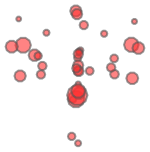

In [78]:
MultiPolygon([Polygon(p) for pc in pcs[0:1] for p in pc])

In [19]:
pcs[0,0].var(axis=0)/ddict['volume'][0,0]

array([0.63085496, 0.63085496])

epoch 0 1.0823830366134644
epoch 1 1.0823817253112793
epoch 2 1.0823801755905151
epoch 3 1.0823780298233032
epoch 4 1.0823742151260376
epoch 5 1.0823657512664795
epoch 6 1.08234441280365
epoch 7 1.082287073135376
epoch 8 1.082130789756775
epoch 9 1.0817009210586548
epoch 10 1.080590844154358
epoch 11 1.078779697418213
epoch 12 1.0783356428146362
epoch 13 1.0779445171356201
epoch 14 1.0772567987442017
epoch 15 1.0781329870224
epoch 16 1.0767126083374023
epoch 17 1.0789378881454468
epoch 18 1.0753065347671509
epoch 19 1.0771256685256958
epoch 20 1.07621431350708
epoch 21 1.0769761800765991
epoch 22 1.0760012865066528
epoch 23 1.0792936086654663
epoch 24 1.0753146409988403
epoch 25 1.0776444673538208
epoch 26 1.07872474193573
epoch 27 1.0750486850738525
epoch 28 1.0764238834381104
epoch 29 1.0753998756408691
epoch 30 1.077006459236145
epoch 31 1.0790400505065918
epoch 32 1.0757249593734741
epoch 33 1.0764336585998535
epoch 34 1.0753744840621948
epoch 35 1.0760183334350586
epoch 36 1.07911

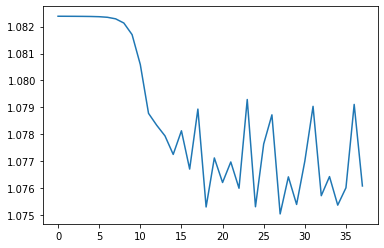

In [18]:
import torch.nn as nn
import torch
from Pytorchtools import EarlyStopping
from SpatialLosses import *
class PointCloudOptimizer(nn.Module):
    
    def __init__(self,
                 norgans,
                 ndim = 2,
                 npoints = 10,
                 hidden_dims = [1000]
                ):
        super(PointCloudOptimizer,self).__init__()
        self.ndim = ndim
        #I have to change the point size to work with spheres evenly
        self.npoints = npoints
        if ndim == 3: 
            i,ii = getSphereSize(npoints)
            self.true_npoints = ii*i
        else:
            self.true_npoints = npoints
        self.norgans = norgans
        self.pcloud_size = int(ndim*npoints)
        input_organ_size = self.pcloud_size + norgans + ndim + 1
        layers = [ nn.Linear(norgans*input_organ_size,hidden_dims[0]) ]
        for i in range(0,len(hidden_dims)-1):
            layers.append(nn.Linear(hidden_dims[i],hidden_dims[i+1]))
            layers.append(nn.BatchNorm1d(hidden_dims[i+1]))
            
        self.output_shape = (norgans,npoints,ndim)
        layers.append(nn.Linear(hidden_dims[-1], norgans*npoints*ndim))
        self.layers = nn.Sequential( *layers )
        self.layers.apply(self.init_weights)
        
    def init_weights(self,layer):
        #make the transform weights zero to start
        #so the output is always a valid polygon when it starts
        if isinstance(layer, nn.Linear):
            nn.init.normal_(layer.weight,mean=0.0,std=0.0)
        
    def make_pclouds(self,x):
        #takes an entry from the centroid, volumes and distances of a patient
        #converts from numpy to torch also
        #c (centroids): norgans x ndim, 
        #v (volume): norgans x 1, 
        #d (distances) norgans x norgans
        [cs,vs,ds] = [i.cpu().detach().numpy() for i in x]
        pclouds = [make_organset_pointcloud(c,v,d,self.npoints) for c,v,d in zip(cs,vs,ds)]
        return torch.tensor(pclouds).float()
        
    def forward(self,x):
        # x is a list [c,v,d] of np arrays
        #c (centroids): len x norgans x ndim, 
        #v (volume): len x norgans x 1, 
        #d (distances) len x norgans x norgans
        
        #makes torch friendly
        #shape len x norgans x true_npoints x ndim
        pointclouds = self.make_pclouds(x)
        pc_shape = pointclouds.shape
        #reshape so it can concatenate with other inputs
        pointclouds = pointclouds.reshape((pc_shape[0],pc_shape[1],-1))
        #now is len x norgans x norgans + ndim + (npoints*ndim)
        out = torch.flatten(torch.cat([pointclouds] + x,dim=2),start_dim=1)
        out = self.layers(out).reshape(pc_shape)
        pointclouds = pointclouds.reshape(pc_shape)
        return out + pointclouds, pointclouds     

def format_pcloud_inputs(ddict):
    oidx = [i for i,o in enumerate(pdata['organs']) if "Masset" not in o]
    v = ddict['volume'][:pcount,oidx].clip(min=.1)
    d = ddict['distances'][:pcount,oidx]
    d = d[:,:,oidx].clip(min=.01)
    #I think volume is in cm3 and distance is mm ?
    d = 10*d
    c = ddict['centroids'][:pcount,oidx,0:ndim]
    c = c - c.mean(axis=0)
    [c, v, d] = [torch.tensor(i).float() for i in [c,v,d]]
    return c, v, d

def train_pcloud_optimizer(ddict, 
                        ndim = 2,
                        npoints = 10,
                        model_path = Const.pytorch_model_dir + 'pcloud.pt',
                        epochs = 1000,
                        lr = .001,
                        centroid_weight = .5,
                        shape_weight = .2,
                        distance_weight = 1
                        ):
    pcount = 20
    c,v,d = format_pcloud_inputs(ddict)

    popt = PointCloudOptimizer(c.shape[1],ndim,npoints = npoints)
    early_stopping = EarlyStopping(patience = 10, path = model_path)
    optimizer = torch.optim.SGD(popt.parameters(),lr =lr)
    loss_hist = []
#     criterion = PointCloudLoss(1,.5)
    for epoch in range(epochs):
        optimizer.zero_grad()
        ypred, ydefault = popt([c,v,d])
        loss = pcloud_loss(ypred,ydefault,
                           c,v,d,
                           shape_weight,centroid_weight,distance_weight)
        loss.backward()
        loss_hist.append(loss.item())
        print('epoch',epoch,loss.item())
        optimizer.step()
        torch.cuda.empty_cache()
        early_stopping(loss.item(),popt)
        if early_stopping.early_stop or torch.isnan(loss):
            print('early stop on epoch',epoch)
            break
    popt.load_state_dict(torch.load(model_path))
    plt.plot(loss_hist)
    return popt.eval(), loss_hist

popt, lh = train_pcloud_optimizer(ddict)

In [ ]:
from shapely.geometry import MultiPoint
pcount = 10
ndim = 2
c,v,d = format_pcloud_inputs(ddict)
ypred,ydefault = popt([c,v,d])
clouds = ypred.cpu().detach().numpy()
MultiPolygon([Polygon(p) for pc in clouds[0:1] for p in pc])

In [ ]:
#the part below is generic notebook analysis

In [ ]:
#checking how many organs are missing in the old dataset
sf = load_spatial_files()
organ_counts = {}
total_patients = 0
for pid, files in sf.items():
    dosefile = files['doses']
    distancefile = files['distances']
    def read_replace(file):
        df = pd.read_csv(file)
        df.replace(to_replace = r'_*GTV.*N', value = '_GTVn', regex = True, inplace = True)
        return df
    dosedf = read_replace(dosefile)
    distdf = read_replace(distancefile)
    dose_rois = set(dosedf['ROI'].dropna())
    dist_rois = set(distdf['Reference ROI'].dropna()).union(set(distdf['Target ROI'].dropna()))
    rois = dose_rois.intersection(dist_rois)
    has_gtv = False
    for r in rois:
        if 'GTV' in r:
            has_gtv = True
    if not has_gtv:
        continue
    else:
        total_patients += 1
    for roi in rois:
        if 'GTV' in roi:
            continue
        currcount = organ_counts.get(roi, 0)
        organ_counts[roi] = currcount + 1
def tempsort(val):
    key = val[0]
    if key in Const.camprt_organs:
        idx = Const.camprt_organs.index(key)
    else:
        idx = 0
    return (.5*val[1]/total_patients) + (2*idx/len(Const.camprt_organs))
values = sorted([(k,v) for k,v in organ_counts.items()], key = tempsort)

In [ ]:
axis = [i for i,v in enumerate(values)]
widths = [x[1] for x in values]
labels = [x[0] for x in values]
colors = []
for label, val in values:
    if label in Const.camprt_organs:
        if val >= total_patients:
            c ='blue'
        else:
            c = 'cyan'
    else:
        c = 'red'
    colors.append(c)
plt.rcParams['figure.figsize'] = [10,30]
fix, ax = plt.subplots()
ax.barh(axis,widths,
         tick_label=labels,
        color = colors,
        log = False)
ax.plot([total_patients,total_patients],[0,len(axis)],"k--")

In [ ]:
np.linalg.norm([1,1,1])